# Benchmark strategy

### Industry breakdown

Pairs trading is a market-neutral trading strategy which removes the need of fundamental 
analysis of equities by creating mean reverting long-short pairs with only statistical methods, whose future 
movements can be predicted, given that their properties stay the same in the out-of-sample
period.

The strategy presented in this notebook was used as a benchmark for my thesis. The companies are from the NIKKEI 225 index from 2010 to 2020. Pairs can only be formed from the same industry, the formation period is 12 months and the trading is 6, the opening signal is 2 standard deviations away from the estimated mean, as I showed in my paper that these are the best parameters to use. I use the Johansen test for cointegration with a VAR model for lag selection.

Detailed results for the statistical tests, thresholds and timeframes can be found in my [thesis](https://github.com/petoczrichard/Pairs-Trading/blob/main/Pair%20Trading%20-%20Richard%20Petocz.pdf) in Tables 1, 2 and 3.

In [32]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import math

from arch.unitroot import ADF as archADF
from matplotlib import gridspec

import itertools
from hurst import compute_Hc, random_walk

from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')
from pylr2 import regress2
from IPython.display import clear_output
from datetime import datetime, date
import calendar

In [33]:
###Parameters
stock_index = 'NIKKEI'          #SNP, NIKKEI, BOVESPA
formation_year = 2016        #2010-2020 - when we take the components of the index
brkdwn = 'Industry'          #Sector/Industry/None
formation_period = 12        #in months, integers only
trading_period = 6          #in months, integers only

#Getting data
comp_stats=pd.read_csv("{}_comp_stats.csv".format(stock_index),index_col=0)
price_data=pd.read_csv("{}_prices2005-2021.csv".format(stock_index),index_col=0)
tickers=pd.read_csv("{}_tickers_2010-2020.csv".format(stock_index),index_col=0)

In [34]:
#Defining formation and trading periods
def create_dates(formation_date):
    trading_start=str(pd.Timestamp(formation_date).date())
    formation_start =str((pd.Timestamp(formation_date)-pd.DateOffset(months=formation_period)).date())
    endD=str((pd.Timestamp(formation_date)+pd.DateOffset(months=trading_period)).date())

    formation_end = str((pd.Timestamp(trading_start)-pd.DateOffset(days=1)).date())
    trading_end = str((pd.Timestamp(endD)-pd.DateOffset(days=1)).date())
    return formation_start, formation_end, trading_start, trading_end

formation_date = '{}-01-01'.format(formation_year)
formation_year = int(formation_date[0:4])
fP1, fP2, tP1, tP2 = create_dates(formation_date)

In [35]:
def clean_data(fP1, tP2, formation_year, stock_index):
    #Only include tickers that are in the stock index for the year and we have data for it
    valid_tickers=(set(price_data[fP1:tP2].columns)) & (set(tickers.loc[formation_year][stock_index]))

    #Drop ticker that miss >20% of their price series, forward fill the rest,
    #then drop the tickers that still has missing values,
    #those can only have it at the start of their price series, would cause problems later in testing
    clean_prices=price_data[fP1:tP2][valid_tickers]
    clean_prices=clean_prices.dropna(axis=1,thresh=round(clean_prices.shape[0]*0.8))
    clean_prices=clean_prices.fillna(method="ffill")
    if pd.isnull(clean_prices.iloc[0]).all():
        clean_prices=clean_prices.drop(clean_prices.index[0], axis=0)
    clean_prices=clean_prices.dropna(axis=1)
    
    return clean_prices

clean_prices = clean_data(fP1, tP2, formation_year, stock_index)

In [36]:
def get_stationary_tickers(clean_prices):
    stat_tics = []
    for i in clean_prices:
        if archADF(clean_prices[fP1:fP2][i]).pvalue < 0.05:
            stat_tics.append(i)
    return stat_tics

stat_tics = get_stationary_tickers(clean_prices)
#Remove stationary price series from the dataset
clean_prices=clean_prices.drop(stat_tics, axis=1)

In [37]:
def get_ticker_brkdwn(brkdwn):
    brkdwn_list=[]
    if brkdwn == 'None':
        brkdwn_list = (list(set(clean_prices)),[])
    else:
        for i in comp_stats[brkdwn].unique():
            brkdwn_list.append(list(comp_stats.loc[clean_prices.columns].query('{}=="{}"'.format(brkdwn,i)).index))
    return brkdwn_list

brkdwn_list = get_ticker_brkdwn(brkdwn)

In [38]:
def get_coint_pairs_johansen(brkdwn_list):
    total = 0
    noPosP = 0
    for i in range(len(brkdwn_list)):
        noPosP += (len(list(itertools.combinations(brkdwn_list[i],2))))

    allPosPairs = pd.DataFrame(columns=['Pair','Joh1sig','Joh2sig','autocorr','LS'],index=np.arange(noPosP))

    for i in range(len(brkdwn_list)):
        for pair in list(itertools.combinations(brkdwn_list[i],2)):
            allPosPairs.iloc[total,0] = pair

            var = VAR(clean_prices[list(pair)][fP1:fP2])
            x = var.select_order()
            model_fitted = var.fit(x.selected_orders['aic'])
            allPosPairs.iloc[total,3] = (acorr_ljungbox(model_fitted.resid.iloc[:,1],lags=x.selected_orders['aic'])[1]<0.05).sum()
            +(acorr_ljungbox(model_fitted.resid.iloc[:,0],lags=x.selected_orders['aic'])[1]<0.05).sum()
            jres = coint_johansen(clean_prices[list(pair)][fP1:fP2],det_order = 0, k_ar_diff = max(0, x.selected_orders['aic']-1))

            allPosPairs.iloc[total,1] = (jres.cvt[0]<jres.lr1[0]).sum()
            allPosPairs.iloc[total,2] = (jres.cvt[1]<jres.lr1[1]).sum()
            if jres.evec[0,0] * jres.evec[1,0] < 0:
                allPosPairs.iloc[total,4] = 1
            else:
                allPosPairs.iloc[total,4] = 0
            total += 1
            #if total % 100 == 0:
            #    clear_output(wait=True)
            #    print(total, '/', noPosP)
    return allPosPairs
allPosPairs = get_coint_pairs_johansen(brkdwn_list)
pairsJ = list(allPosPairs.query('Joh1sig>=2 & Joh2sig<2 & autocorr==0 & LS==1').Pair)
print(allPosPairs.shape[0])
print(len(pairsJ))

446
16


In [39]:
def JohSpr(pair):
    pair = list(pair)
    var = VAR(clean_prices[list(pair)][fP1:fP2])
    x = var.select_order()
    jres = coint_johansen(clean_prices[list(pair)][fP1:fP2],det_order = 0, k_ar_diff=max(0,x.selected_orders['aic']-1))
    spr = (clean_prices[pair][fP1:fP2]*jres.evec[:,0]).sum(axis=1)
    
    meanSpr = spr.mean()
    stdSpr = spr.std()
    normSpr = ((clean_prices[pair][fP1:tP2]*jres.evec[:,0]).sum(axis=1)-meanSpr)/stdSpr
    return normSpr, jres.evec[:,0], stdSpr

def pos_func(nSpr, entries, weights, stoploss=np.nan, block=False, push=True):
    posit = pd.Series(np.nan, index=nSpr[tP1:tP2].index, name='Pos')
    posit.iloc[0] = 0
    posit[nSpr*nSpr.shift(1) < 0] = 0
    for i in np.arange(len(entries)):
        posit[(nSpr+entries[i])*(nSpr.shift(1)+entries[i])< 0] = weights[i]
        posit[(nSpr-entries[i])*(nSpr.shift(1)-entries[i])< 0] = -weights[i]
    if not np.isnan(stoploss):
        posit[(nSpr+float(stoploss))*(nSpr.shift(1)+float(stoploss))< 0] = 0
        posit[(nSpr-float(stoploss))*(nSpr.shift(1)-float(stoploss))< 0] = 0
    else:
        block=False
    posit.ffill(inplace=True)
    
    if len(entries) > 1:
        for i in range(1,len(posit)):
            if abs(posit).values[i]>abs(posit).values[i-1] or abs(posit).values[i]==0 or \
            posit.values[i]*posit.values[i-1]<0:
                posit.values[i]=posit.values[i].copy()
            else:
                posit.values[i]=posit.values[i-1].copy()
    if block:
        if not nSpr[(nSpr>float(stoploss)) | (nSpr<-float(stoploss))].empty:
            posit[nSpr[(nSpr>float(stoploss)) | (nSpr<-float(stoploss))].index[0]:] = 0
    if push:
        posit=posit.shift(1)
        posit.iloc[0]=0
    return posit

def equity_curve(positions, df, weiV, initial_cash=100, leverage=2,shorting_cost=0.01,commission=0.0008,market_impact=0.002):
    trades=positions.diff()
    trades.iloc[0]=positions[0]-0
    cash=pd.Series(data=np.nan,index=positions.index,name='Cash')
    portfolio=pd.Series(data=np.nan,index=positions.index,name='Portfolio')
    shares=pd.Series(data=np.nan,index=positions.index,name='Shares')
    transaction_costs=pd.Series(data=np.nan,index=positions.index,name='Tc')
    
    portfolio.iloc[0]=initial_cash
    shares.iloc[0]=leverage*portfolio.iloc[0]/abs(df*weiV).sum(axis=1)[0]
    cash.iloc[0]=portfolio.iloc[0]-(shares[0]*df.iloc[0]*weiV*trades[0]).sum()
    transaction_costs.iloc[0]=abs(shares[0]*weiV*df.iloc[0]*trades[0]).sum()*(commission+market_impact)+(shares[0]*positions[0]*df.iloc[0]*weiV).combine(0, min).sum()*(-shorting_cost/252)

    for i in range(1,len(cash)):
        if ~(((positions[i]>0) & (trades[i]>0)) | ((positions[i]<0) & (trades[i]<0))):
            shares.iloc[i]=shares.iloc[i-1]
        else:
            shares.iloc[i]=leverage*portfolio.iloc[i-1]/abs(df*weiV).sum(axis=1)[i]
        transaction_costs.iloc[i]=abs(shares[i]*weiV*df.iloc[i]*trades[i]).sum()*(commission+market_impact)+(shares[i]*positions[i]*df.iloc[i]*weiV).combine(0, min).sum()*(-shorting_cost/252)
        cash.iloc[i]=cash.iloc[i-1]-(shares[i]*df.iloc[i]*weiV*trades[i]).sum()-transaction_costs.iloc[i]
        portfolio.iloc[i]=cash.iloc[i]+(shares[i]*positions[i]*df.iloc[i]*weiV).sum()
        
    return portfolio

In [40]:
pair_NAVs = pd.DataFrame()
slHit = 0
avgTr = []
for c, pair in enumerate(pairsJ):
    nSpr, weiV, stdSpr = JohSpr(list(pair))
    oosNSpr = nSpr[tP1:tP2]
    positions = pos_func(oosNSpr,entries=np.array([2]),weights=np.array([1.0]),block=True,stoploss=5)
    port = equity_curve(positions, clean_prices[list(pair)][tP1:tP2], weiV,shorting_cost=0.0,commission=0.0,market_impact=0.0)
    pair_NAVs = pd.concat([pair_NAVs, port], axis=1)
    #if c%10==0:
    #    clear_output(wait=True)
    #    print(c,'/',len(pairsJ))
    
    if any(abs(oosNSpr)>5):
        slHit += 1
        avgTr.append((abs(positions.diff()).sum()/2)-1)
    else:
        avgTr.append(abs(positions.diff()).sum()/2)
    
    
strat_values = pair_NAVs.mean(axis=1)

MDD=pd.Series(np.nan,index=strat_values.index)
MDD[0]=1
for i in range(1, len(MDD)):
    MDD[i]=min(1,MDD[i-1]*(1+strat_values.pct_change()[i]))

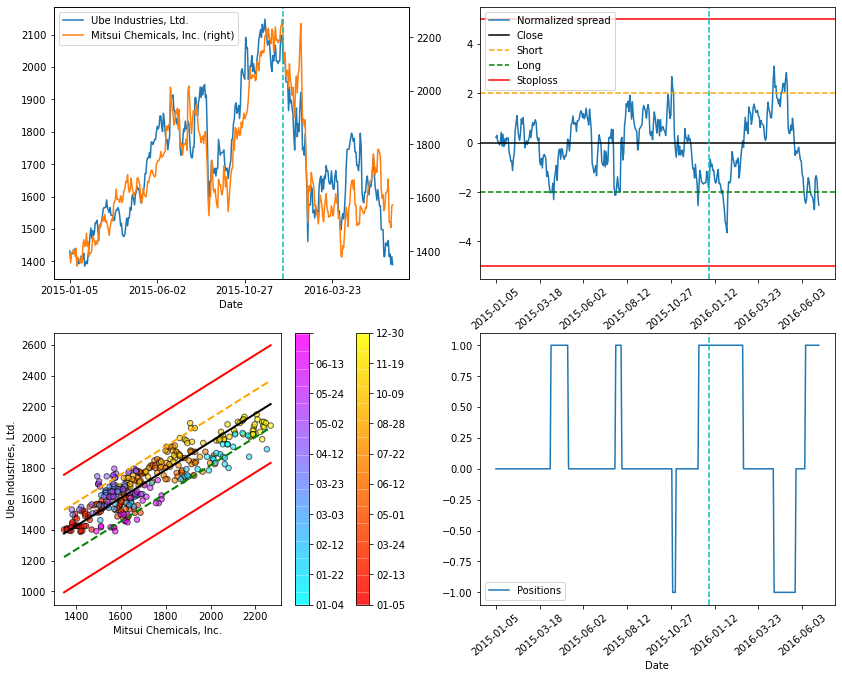

In [43]:
pair = list(pairsJ[8])

normSpr, weiV, stdSpr = JohSpr(pair)

intercept = (clean_prices[pair][fP1:fP2]@(weiV/weiV[0])).mean()
spr = (clean_prices[pair][fP1:fP2]@(weiV/weiV[0])).std()
slope = -(weiV/weiV[0])[1]
x1 = np.array([clean_prices[pair[1]][fP1:tP2].min()*1,clean_prices[pair[1]][fP1:tP2].max()*1])
y1 = np.array([intercept+slope*clean_prices[pair[1]][fP1:tP2].min()*1,intercept+slope*clean_prices[pair[1]][fP1:tP2].max()*1])
positions= pd.DataFrame(np.nan, index=normSpr.index, columns=['Pos'])
positions['Pos'][0] = 0
positions['Pos'][normSpr*normSpr.shift(1) < 0] = 0
positions['Pos'][normSpr> 2 ]= -1
positions['Pos'][normSpr< -2 ] = +1
positions['Pos'].ffill(inplace=True)
positions=positions.shift(1)
positions.iloc[0]=0

plt.subplot(2,2,1)
S1 = clean_prices[pair[0]][fP1:tP2]
S1.name = comp_stats.loc[pair[0]].Name
S2 = clean_prices[pair[1]][fP1:tP2]
S2.name = comp_stats.loc[pair[1]].Name
S1.plot(legend=True);
S2.plot(secondary_y=True,mark_right=True,legend=True);
plt.xticks(rotation=40)
plt.axvline(clean_prices[fP1:fP2].shape[0], color='c', linestyle='--');
plt.subplot(2,2,2)
normSpr[fP1:tP2].plot(figsize=(14,11));
plt.axhline(0, color='black');
plt.axhline(2, color='orange', linestyle='--');
plt.axhline(-2, color='g', linestyle='--');
plt.axhline(5, color='r', linestyle='-');
plt.axhline(-5, color='r', linestyle='-');
plt.axvline(clean_prices[fP1:fP2].shape[0], color='c', linestyle='--');
plt.xticks(rotation=40)
plt.legend(['Normalized spread', 'Close', 'Short', 'Long','Stoploss']);
plt.subplot(2,2,3)
cm = plt.get_cmap('autumn')
S1 = clean_prices[pair[1]][fP1:fP2]
S2 = clean_prices[pair[0]][fP1:fP2]
colors = np.linspace(0.1, 1, len(S1))
sc = plt.scatter(S1, S2, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.6, marker='o')
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([p[5:] for p in S1[::len(S1)//9].index]);

cm = plt.get_cmap('cool')
S1 = clean_prices[pair[1]][tP1:tP2]
S2 = clean_prices[pair[0]][tP1:tP2]
colors = np.linspace(0.1, 1, len(S1))
sc = plt.scatter(S1, S2, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.6, marker='o')
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([p[5:] for p in S1[::len(S1)//9].index]);

plt.xlabel(comp_stats.loc[pair[1]].Name);
plt.ylabel(comp_stats.loc[pair[0]].Name);
plt.plot(x1,y1,'k',alpha=1, linewidth=2);
plt.plot(x1,y1+2*spr,ls='--',c='orange',alpha=1, linewidth=2);
plt.plot(x1,y1-2*spr,'g--',alpha=1, linewidth=2);
plt.plot(x1,y1+5*spr,'r',alpha=1, linewidth=2);
plt.plot(x1,y1-5*spr,'r',alpha=1, linewidth=2);

plt.subplot(2,2,4)
positions['Pos'].plot();
plt.axvline(clean_prices[fP1:fP2].shape[0], color='c', linestyle='--');
plt.legend(['Positions']);
plt.xticks(rotation=40);

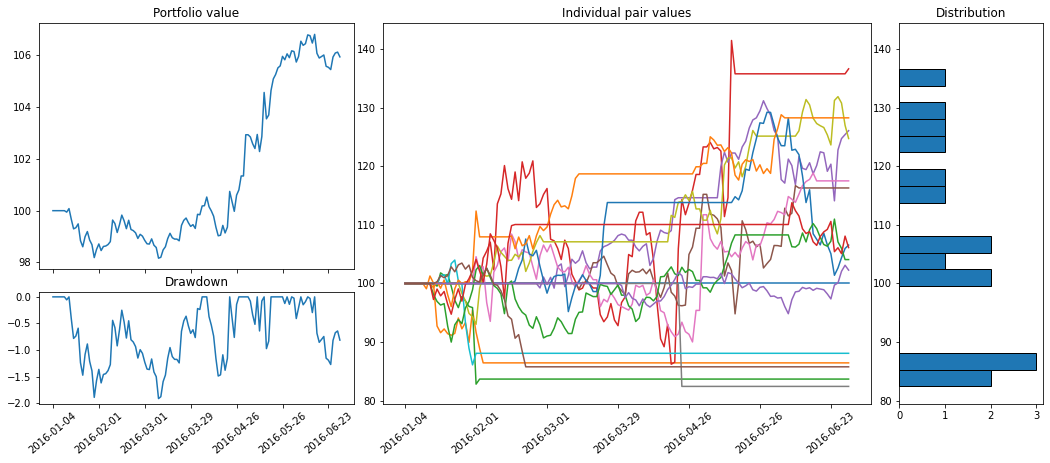

In [42]:
def plot_result():
    fig = plt.figure(figsize=(18,7));
    gs = plt.GridSpec(3,6);

    axis1 = plt.subplot(gs[0:2,0:2]);
    strat_values.plot();
    plt.title('Portfolio value');
    axis2 = plt.subplot(gs[2,0:2],sharex=axis1);
    ((MDD-1)*100).plot();
    plt.title('Drawdown');
    plt.xticks(rotation=40);
    axis3 = plt.subplot(gs[0:3,2:5]);
    for i in range(0, len(pairsJ)):
        pair_NAVs.iloc[:,i].plot(linestyle='-',legend=False);
    plt.title('Individual pair values');
    plt.xticks(rotation=40);
    axis4 = plt.subplot(gs[0:3,5],sharey=axis3);
    n = math.ceil((pair_NAVs.iloc[-1].max() - pair_NAVs.iloc[-1].min())/3);
    plt.hist(pair_NAVs.iloc[-1], bins = n, orientation='horizontal',linewidth = 1, ec='k');
    plt.title('Distribution');
    plt.show();
    
plot_result()

In [44]:
###Parameters
stock_index = 'NIKKEI'          #SNP, NIKKEI, BOVESPA
brkdwn = 'Industry'          #Sector/Industry
formation_period = 12        #in months, integers only
trading_period = 6          #in months, integers only

#Getting data
comp_stats=pd.read_csv("{}_comp_stats.csv".format(stock_index),index_col=0)
price_data=pd.read_csv("{}_prices2005-2021.csv".format(stock_index),index_col=0)
tickers=pd.read_csv("{}_tickers_2010-2020.csv".format(stock_index),index_col=0)

In [45]:
strat_returns=pd.DataFrame()
allConsDates = ['2010-01-01']
i = 1
while int(allConsDates[-1][0:4])<2021:
    allConsDates.append(str((pd.Timestamp('2010-01-01')+pd.DateOffset(months=trading_period*i)).date()))
    i += 1
allConsDates.pop()
pairsData = pd.DataFrame(0,columns=['All','Selected','StoplossHit','Profitable','AvgTrade'],index=allConsDates)

for formation_date in allConsDates:
    formation_year = int(formation_date[0:4])
    fP1, fP2, tP1, tP2 = create_dates(formation_date)
    
    clean_prices = clean_data(fP1, tP2, formation_year, stock_index)
    stat_tics = get_stationary_tickers(clean_prices)
    clean_prices=clean_prices.drop(stat_tics, axis=1)
    brkdwn_list = get_ticker_brkdwn(brkdwn)
    allPosPairs = get_coint_pairs_johansen(brkdwn_list)
    pairsJ = list(allPosPairs.query('Joh1sig>=2 & Joh2sig<2 & autocorr==0 & LS==1').Pair)
    noPosP = allPosPairs.shape[0]
    
    pair_NAVs = pd.DataFrame()
    slHit = 0
    avgTr = []
    for c, pair in enumerate(pairsJ):
        nSpr, weiV, stdSpr = JohSpr(list(pair))
        oosNSpr = nSpr[tP1:tP2]
        positions = pos_func(oosNSpr,entries=np.array([2]),weights=np.array([1.0]),block=True,stoploss=5)
        port = equity_curve(positions, clean_prices[list(pair)][tP1:tP2], weiV,shorting_cost=0.0,commission=0.0,market_impact=0.0)
        pair_NAVs = pd.concat([pair_NAVs, port], axis=1)
        #if c%10==0:
        #    clear_output(wait=True)
        #    print(c,'/',len(pairsJ))

        if any(abs(oosNSpr)>5):
            slHit += 1
            avgTr.append(max(0,(abs(positions.diff()).sum()/2)-1))
        else:
            avgTr.append(abs(positions.diff()).sum()/2)
    pairsData.loc[formation_date,'StoplossHit'] = slHit
    pairsData.loc[formation_date,'All'] = noPosP
    pairsData.loc[formation_date,'Selected'] = len(pairsJ)
    pairsData.loc[formation_date,'Profitable'] = (pair_NAVs.iloc[-1]>100).sum()
    pairsData.loc[formation_date,'AvgTrade'] = sum(avgTr)/len(avgTr)

    
    strat_values = pair_NAVs.mean(axis=1)
    if strat_values.empty:
        strat_values=pd.Series(100,index=clean_prices[tP1:tP2].index)
        
    MDD=pd.Series(np.nan,index=strat_values.index)
    MDD[0]=1
    for i in range(1, len(MDD)):
        MDD[i]=min(1,MDD[i-1]*(1+strat_values.pct_change()[i]))
        
    strat_returns=pd.concat([strat_returns,strat_values.pct_change()],axis=0)
    
    #print('Date:',formation_date)
    #print('Final value:',strat_values[-1])
    #print('Pairs:',len(pairsJ),'/',noPosP,'\n')

    #plot_result();

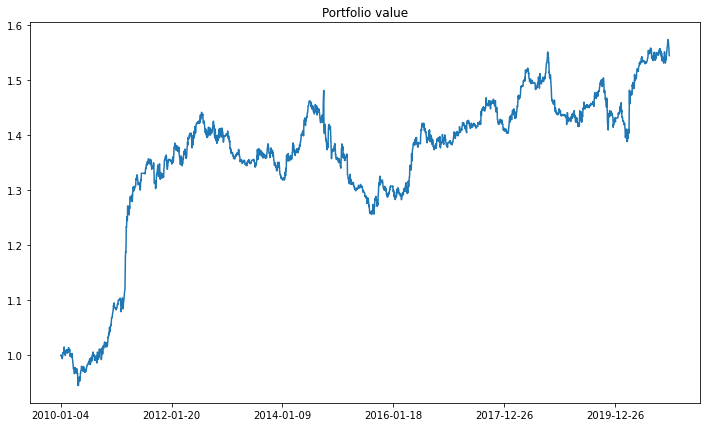

In [52]:
strat_eq=(strat_returns.fillna(0)+1).cumprod()
strat_eq.plot(figsize=(12,7),legend=False);
plt.title('Portfolio value');

In [47]:
MDD=pd.Series(np.nan,index=strat_eq.index)
MDD[0]=1
for i in range(1, len(MDD)):
    MDD[i]=min(1,MDD[i-1]*(1+strat_eq.pct_change().squeeze()[i]))
    
MDD=pd.DataFrame(data=MDD,columns=['MDD'])
MDD['Periods']=(np.where((MDD!=1) & (MDD.shift(1)==1),1,0)).cumsum()
MDD['Periods']=(np.where((MDD['MDD']==1) & (MDD['MDD'].shift(1)==1),0,MDD['Periods']))
temp_rows=[]
for i in range(1,MDD['Periods'].max()+1):
    #print(f"{(MDD[MDD['Periods']==i]['MDD'].min()-1)*100:.2f}%")
    drawdown=(MDD[MDD['Periods']==i]['MDD'].min()-1)
    length=len(MDD[MDD['Periods']==i])
    start=MDD[MDD['Periods']==i].iloc[0].name
    end=MDD[MDD['Periods']==i].iloc[-1].name
    temp_rows.append([drawdown, length, start, end])
temp_rows
MDD_stats=pd.DataFrame(data=temp_rows,columns=['Drawdown','Length','Start','End'])

monthly_strat2=[strat_eq.iloc[0].item()]
for year in range(2010,2021):
    for month in range(1,13):
        monthly_strat2.append(strat_eq[:str(date(year,month,calendar.monthrange(year, month)[1]))].iloc[-1].item())

,Drawdown,Length,Start,End
50,-0.151867,888,2014-10-03,2018-04-11
59,-0.104755,453,2018-10-02,2020-08-12
47,-0.085292,479,2012-08-06,2014-06-19
2,-0.068841,175,2010-01-28,2010-10-14
30,-0.039896,76,2011-08-17,2011-12-07


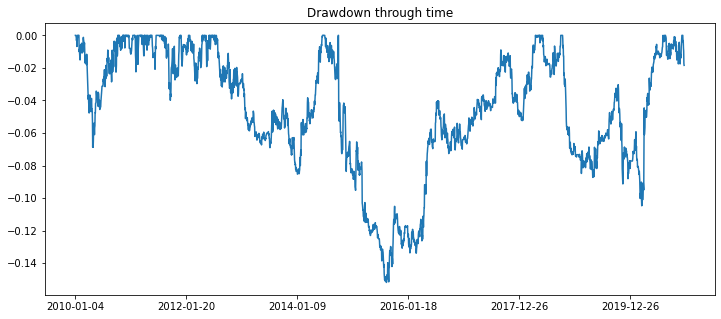

In [53]:
(MDD['MDD']-1).plot(figsize=(12,5));
plt.title('Drawdown through time')
MDD_stats.sort_values(by='Drawdown',ascending=True).head(5)

In [54]:
print('Annual excess return:',strat_eq.iloc[-1].item()**(1/11)-1-0.0055)
print('Annual volatility:',(np.std(strat_returns.fillna(0))*(len(strat_returns.fillna(0))/11)**.5).item())
print('Sharpe ratio:',((strat_eq.iloc[-1].item()**(1/11)-1)-0.0055)/((np.std(strat_returns.fillna(0))*(len(strat_returns.fillna(0))/11)**.5).item()))
print('Positive months:',(pd.Series(monthly_strat2).pct_change()>0).sum(),'/ 132\t',(pd.Series(monthly_strat2).pct_change()>0).sum()/132)

Annual excess return: 0.034774467874406474
Annual volatility: 0.06144592038941873
Sharpe ratio: 0.565936154166466
Positive months: 79 / 132	 0.5984848484848485


In [55]:
pairsData.mean()

All            423.727273
Selected        21.454545
StoplossHit      9.863636
Profitable       9.181818
AvgTrade         0.696531
dtype: float64